In [60]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv("prosperLoanData.csv") # the full dataset

### Dropped column names

In [3]:
dropped = ['ListingNumber', 'LoanNumber', 'GroupKey', 'LoanKey', 'MemberKey', 'ListingKey']

In [4]:
for col in data.columns :
    if (data[col].isnull().sum() > 0) and col not in dropped:
        sum_null = data[col].isnull().sum()
        percent_null = (sum_null/data.shape[0]) * 100
        if percent_null > 70 :
            dropped.append(col)

## Data Preprocessing

### Imputing `CreditGrade` & `ProsperRating (Alpha)` 

In [5]:
data['CreditGrade'].fillna(data['ProsperRating (Alpha)'],inplace=True)

In [6]:
dropped.extend(['ProsperRating (Alpha)','ProsperRating (numeric)'])
dropped.remove('CreditGrade')

In [7]:
data.drop(dropped,axis=1,inplace=True)

### Filling missing values

In [8]:
data.isnull().sum().sort_values(ascending=False)

ClosedDate                 58848
EstimatedReturn            29084
ProsperScore               29084
EstimatedEffectiveYield    29084
EstimatedLoss              29084
                           ...  
LenderYield                    0
BorrowerRate                   0
LoanStatus                     0
Term                           0
Investors                      0
Length: 64, dtype: int64

In [9]:
for col in data.select_dtypes('float64').columns:
    if data[col].isnull().sum() > 0: 
        data[col].fillna(data[col].median(),inplace=True)
data.select_dtypes('float64').isnull().sum().sum()

0

In [10]:
for col in data.select_dtypes('int64').columns: 
    if data[col].nunique() > 100:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna(data[col].mode(), inplace=True)
data.select_dtypes('int64').isnull().sum().sum()

0

In [11]:
for col in data.columns :
    if data[col].isnull().sum() > 0 :
        data[col].fillna(data[col].mode()[0],inplace=True)
data.isnull().sum().sum()

0

### Imputing Dates

In [12]:
date =['FirstRecordedCreditLine','DateCreditPulled','ListingCreationDate','ClosedDate','LoanOriginationDate']
# convert date columns from object to datetime 
for i in date:
    #to get ride of time convert data to datetime
    data[i]=pd.to_datetime(data[i])
    data[i]=data[i].dt.date  # datatype=object
    # split each coloumn to year month day then delet it 
    data[f'{i}_year']= pd.DatetimeIndex(data[f'{i}']).year
    data[f'{i}_month']= pd.DatetimeIndex(data[f'{i}']).month
    data[f'{i}_day']= pd.DatetimeIndex(data[f'{i}']).day
    del(data[f'{i}'])

### Detecting Outliers

In [13]:
for col in data.columns:
        if (((data[col].dtype)=='float64') | ((data[col].dtype)=='int64')):
            percentiles = data[col].quantile([0.25,0.75]).values
            iqr = percentiles[1] - percentiles[0]
            lower_bound = percentiles[0] -(1.5 * iqr) 
            upper_bound = percentiles[1] +(1.5 * iqr)
            data[col].loc[data[col] < lower_bound] = lower_bound
            data[col].loc[data[col] > upper_bound] = upper_bound
        else:
            data[col]=data[col]

c:\users\alaa_\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Imputing Target Value

In [14]:
def target_handling(row): 
    if row == 'Completed':
        return 1
    else:
        return 0

data['Status'] = data['LoanStatus'].apply(target_handling)
data.drop('LoanStatus',axis=1,inplace=True)

### Encoding 

In [15]:
obj = data.select_dtypes('object')
obj.nunique()

CreditGrade                8
BorrowerState             51
Occupation                67
EmploymentStatus           8
IncomeRange                8
LoanOriginationQuarter    33
dtype: int64

In [16]:
### one hot encoding
dummies = pd.get_dummies(data[['CreditGrade', 'EmploymentStatus', 'IncomeRange','LoanOriginationQuarter']], drop_first=True)

In [17]:
## label enc
le = LabelEncoder()
data[['BorrowerState','Occupation']] = data[['BorrowerState','Occupation']].apply(le.fit_transform)

In [18]:
data = pd.concat([data.drop(obj,axis=1),dummies],axis=1)

In [19]:
data.select_dtypes('object')

""
0
1
2
3
4
...
113932
113933
113934
113935


In [20]:
data

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,...,LoanOriginationQuarter_Q3 2013,LoanOriginationQuarter_Q4 2005,LoanOriginationQuarter_Q4 2006,LoanOriginationQuarter_Q4 2007,LoanOriginationQuarter_Q4 2008,LoanOriginationQuarter_Q4 2009,LoanOriginationQuarter_Q4 2010,LoanOriginationQuarter_Q4 2011,LoanOriginationQuarter_Q4 2012,LoanOriginationQuarter_Q4 2013
0,36,0.16516,0.1580,0.1380,0.16150,0.0724,0.09170,6.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,36,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,7.0,2,44.0,...,0,0,0,0,0,0,0,0,0,0
2,36,0.28269,0.2750,0.2400,0.16150,0.0724,0.09170,6.0,0,67.0,...,0,0,0,0,0,0,0,0,0,0
3,36,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,9.0,6,113.0,...,0,0,0,0,0,0,0,0,1,0
4,36,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,4.0,2,44.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,36,0.22354,0.1864,0.1764,0.16490,0.0699,0.09500,5.0,1,246.0,...,0,0,0,0,0,0,0,0,0,0
113933,36,0.13220,0.1110,0.1010,0.10070,0.0200,0.08070,8.0,6,21.0,...,0,0,0,0,0,0,0,1,0,0
113934,36,0.23984,0.2150,0.2050,0.18828,0.1025,0.08578,3.0,1,84.0,...,0,0,0,0,0,0,0,0,0,1
113935,36,0.28408,0.2605,0.2505,0.24450,0.0850,0.15142,5.0,2,94.0,...,0,0,0,0,0,0,0,1,0,0


### Feature Selection

In [21]:
corrlation = data.corrwith(data['Status']).sort_values(ascending = False)
sel_col = corrlation[(corrlation > 0.2) | (corrlation < -0.2)]
sel_col.drop('Status',inplace=True)

In [22]:
sel_col

LP_CustomerPrincipalPayments      0.598982
LoanMonthsSinceOrigination        0.510850
LP_CustomerPayments               0.495638
ClosedDate_day                    0.490288
ClosedDate_month                  0.402958
EmploymentStatus_Full-time        0.379045
Investors                         0.209813
MonthlyLoanPayment               -0.211909
LoanOriginationQuarter_Q1 2014   -0.240852
LoanOriginalAmount               -0.246836
LoanOriginationQuarter_Q4 2013   -0.248185
ClosedDate_year                  -0.465317
DateCreditPulled_year            -0.507319
LoanOriginationDate_year         -0.508132
ListingCreationDate_year         -0.508645
dtype: float64

In [23]:
data_copy = data.drop(sel_col.index,axis=1)

#### Feature Extraction

Normalization and PCA

In [24]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
data_copy = scaler.fit_transform(data_copy)

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
data_copy_out = pca.fit_transform(data_copy)

In [26]:
data_copy_out.shape

(113937, 5)

In [27]:
pca.explained_variance_ratio_

array([0.46135327, 0.42102229, 0.06439477, 0.0267006 , 0.02568215])

In [28]:
pca_data = pd.DataFrame(data=data_copy_out,columns=['col1','col2','col3','col4','col5'])

In [29]:
new_data = pd.concat([data[sel_col.index],pca_data],axis=1)

In [30]:
new_data

,LP_CustomerPrincipalPayments,LoanMonthsSinceOrigination,LP_CustomerPayments,ClosedDate_day,ClosedDate_month,EmploymentStatus_Full-time,Investors,MonthlyLoanPayment,LoanOriginationQuarter_Q1 2014,LoanOriginalAmount,LoanOriginationQuarter_Q4 2013,ClosedDate_year,DateCreditPulled_year,LoanOriginationDate_year,ListingCreationDate_year,col1,col2,col3,col4,col5
0,9248.665,78.0,11396.1400,14,8.0,0,258.0,330.43,0,9425,0,2009.0,2007.0,2007.0,2007.0,0.709912,-0.278916,0.192722,-0.121120,0.160290
1,0.000,0.0,0.0000,4,3.0,0,1.0,318.93,1,10000,0,2014.0,2014.0,2014.0,2014.0,0.388572,0.329822,-0.133688,-0.002813,-0.070494
2,3001.000,86.0,4186.6300,17,10.5,0,41.0,123.32,0,3001,0,2009.0,2007.0,2007.0,2007.0,-0.261381,0.099155,0.093808,-0.082823,-0.024337
3,4091.090,16.0,5143.2000,4,3.0,0,158.0,321.45,0,10000,0,2014.0,2012.0,2012.0,2012.0,0.500570,0.700750,0.092471,0.166378,0.098338
4,1563.220,6.0,2819.8500,4,3.0,0,20.0,563.97,0,15000,0,2014.0,2013.0,2013.0,2013.0,0.138780,-0.470254,-0.225306,0.012392,0.048599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,2238.380,11.0,3647.4000,4,3.0,0,1.0,364.74,0,10000,0,2014.0,2013.0,2013.0,2013.0,-0.187160,-0.204899,-0.012440,-0.094262,-0.002076
113933,1997.160,28.0,2330.5500,4,3.0,0,22.0,65.57,0,2000,0,2014.0,2011.0,2011.0,2011.0,-0.207164,-0.016918,-0.129987,-0.024550,-0.039392
113934,183.150,3.0,546.7000,4,3.0,0,119.0,273.35,0,10000,1,2014.0,2013.0,2013.0,2013.0,-0.420789,0.118902,0.048847,0.046669,0.000266
113935,9248.665,28.0,12362.3600,13,8.0,1,274.0,449.55,0,15000,0,2013.0,2011.0,2011.0,2011.0,-0.276763,-0.026114,0.064938,-0.131403,0.097606


## Modeling

Note : multinominal naive bayes is feeded by the dataset without PCA 

In [31]:
X = new_data
y= data['Status']

In [49]:
X_nb = data[sel_col.index]
y_nb= data['Status']

In [50]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_smot,y_smot = smote.fit_resample(X,y)
X_smot2,y_smot2 = smote.fit_resample(X_nb,y_nb)

In [51]:
## we did multi Train_test_split since multinomial naive bayes don't accept PCA values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_smot2, y_smot2, test_size=0.33, random_state=52)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_smot, y_smot, test_size=0.33, random_state=42)

In [34]:
# parms = {
#     'C':[0.01, 0.1, 1],
#     'solver': ['lbfgs', 'liblinear', 'sag'],     
# }
# LR = LogisticRegression() 
# clf = GridSearchCV(LR, parms)
# clf.fit(X_train,y_train)

# clf.best_params_

In [55]:
clf = LogisticRegression(random_state=0,C=.01,solver='sag').fit(X_train, y_train)
pred_log = clf.predict(X_test)
logreg_train_score = pred_log.score(X_train,y_train)
accuracy_score(y_test,pred_log)

c:\users\alaa_\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9478330337527462

In [36]:
# from sklearn.linear_model import Perceptron
# parms = {
#     'alpha':[.1, 0.01, 0.001, .0001],
#     'max_iter': [100, 200,500,1000],     
# }
# per = Perceptron() 
# clf = GridSearchCV(per, parms)
# clf.fit(X_train,y_train)
# clf.best_params_

In [112]:
from sklearn.linear_model import Perceptron
percp = Perceptron(alpha=.1,max_iter=100).fit(X_train,y_train)
perd_perceptron = percp.predict(X_test)
perc_train_score = percp.score(X_train,y_train)
accuracy_score(y_test,perd_perceptron)

0.9354104254044338

In [39]:
from sklearn.neural_network import MLPClassifier
percp = MLPClassifier(hidden_layer_sizes=2,solver='adam').fit(X_train,y_train)
mlp_pred = percp.predict(X_test)
accuracy_score(y_test,mlp_pred)

0.9851408028759736

In [ ]:
# criterion = ['gini', 'entropy']
# max_depth = [2,4,6,8,10,12]
# parameters = dict(criterion=criterion,max_depth=max_depth)
# clf_GS = GridSearchCV(dt_cl, parameters)
# clf_GS.fit(X_train,y_train)
# print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
# print('Best max_depth:', clf_GS.best_estimator_.get_params()['max_depth'])

In [119]:
from sklearn import tree
dt_cl = tree.DecisionTreeClassifier(criterion="entropy",max_depth =10,min_samples_split=2,min_samples_leaf=1)
dt_cl.fit(X_train,y_train)
dt_pred = dt_cl.predict(X_test)
dt_train_score = dt_cl.score(X_train,y_train)
accuracy_score(y_test,dt_pred)

0.9914919113241462

In [58]:
from sklearn.naive_bayes import  MultinomialNB
clf_Multi = MultinomialNB()
clf_Multi.fit(X_train2,y_train2)
prediction_multi=clf_Multi.predict(X_test2)
multi_train_score = clf_Multi.score(X_train2,y_train2)
accuracy_score(y_test2,prediction_multi)

0.8896345116836429

### Models Evaluation

##### confusion matrix

In [61]:
logreg_cm = confusion_matrix(y_test,pred_log)
percep_cm = confusion_matrix(y_test,pred_perceptron)
mlp_cm = confusion_matrix(y_test,mlp_pred)
dt_cm = confusion_matrix(y_test,dt_pred)
nv_cm = confusion_matrix(y_test,prediction_multi)


In [107]:
cm_list = [logreg_cm,percep_cm,mlp_cm,dt_cm,nv_cm]
cm_title = ['logreg_cm','percep_cm','mlp_cm','dt_cm','nv_cm']

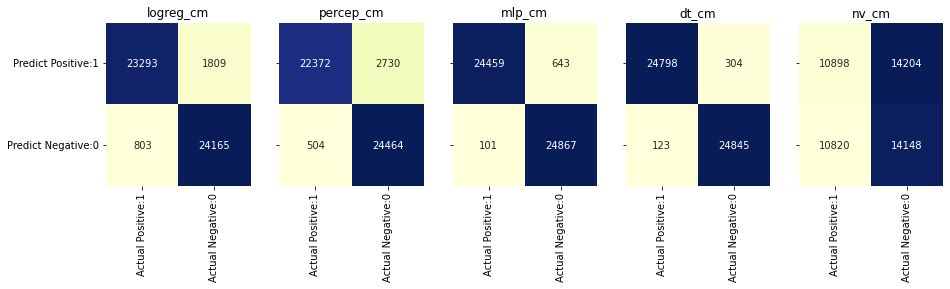

In [108]:
f,ax = plt.subplots(1,5,sharey=True,figsize=(15,3))
for i in range(0,len(cm_list)) :
    cm_matrix = pd.DataFrame(data=cm_list[i], columns=['Actual Positive:1', 'Actual Negative:0'], 
                                     index=['Predict Positive:1', 'Predict Negative:0'])
    g1 = sns.heatmap(cm_matrix,annot=True, fmt='d',cmap="YlGnBu",cbar=False,ax=ax[i])
    g1.set_title(cm_title[i])

##### Train & Test Scores

In [114]:
print('Logistic Regression')
print(f'Train score = {logreg_train_score} Test Score ={accuracy_score(y_test,pred_log)}')

perceptron
Train score = 0.98636578263949 Test Score =0.9478330337527462


In [115]:
print('perceptron')
print(f'Train score = {perc_train_score} Test Score ={accuracy_score(y_test,perd_perceptron)}')

perceptron
Train score = 0.9385378138034154 Test Score =0.9354104254044338


In [120]:
print('Decision Tree Classifer')
print(f'Train score = {dt_train_score} Test Score ={accuracy_score(y_test,dt_pred)}')

Decision Tree Classifer
Train score = 0.9946584559691508 Test Score =0.9914919113241462


In [122]:
print('Multinomial Naive Bayes')
print(f'Train score = {multi_train_score} Test Score ={accuracy_score(y_test2,prediction_multi)}')

Multinomial Naive Bayes
Train score = 0.8895982529314551 Test Score =0.8896345116836429


# Addtional

Feature imporatnces plot for `Decision Tree` model

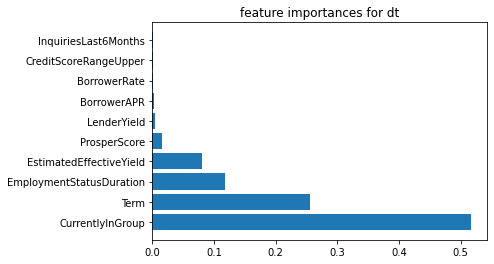

In [123]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances for dt')
    plt.show()
f_importances(abs(dt_cl.feature_importances_), data.columns , top=10)

`Gaussian Naive Bayes` model but not very promising

In [125]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train2, y_train2)
y_pred = gnb.predict(X_test2)
accuracy_score(y_test2,y_pred)

0.8431595765927701